# Perform cluster lensing analysis on DC2 data and compare results from the extragalactic and object catalogs for DC2 Run 2.1i

This was put together using:
- the DC2 analysis tutorials (in particular `matching_fof.ipynb` and `object_gcr_2_lensing_cuts.ipynb`)
- the CLMM usage examples


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs
from GCR import GCRQuery

In [7]:
#sorted(list(GCRCatalogs.get_available_catalogs().keys()))

In [8]:
# load object catalog (for a single tract)
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.1i_dr1')

In [9]:
#sorted(object_cat.list_all_native_quantities())
#sorted(q for q in object_cat.list_all_native_quantities() if 'shape' in q)

In [10]:
tracts = object_cat.available_tracts
print(len(tracts))

168


/global/homes/c/ccombet/.conda/envs/clmmenv/lib/python3.8/site-packages/GCRCatalogs-0.15.0-py3.8.egg/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/homes/c/ccombet/.conda/envs/clmmenv/lib/python3.8/site-packages/GCRCatalogs-0.15.0-py3.8.egg/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


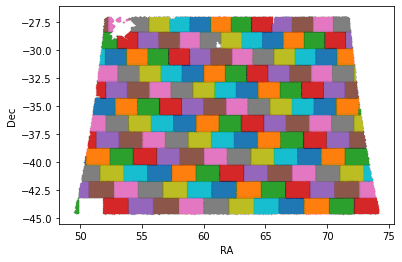

In [7]:
# Let's first visually inspect the footprint of the object catalog.
# When `return_iterator` is turned on, the method `get_quantities` will return an 
# iterator, and each element in the iterator will be the quantities we requested in 
# different chunks of the dataset. 

# For object catalogs, the different chunks happen to be different patches, 
# resulting in a different color for each patch in the scatter plot below.
for my_tract in tracts: 
    for object_data in object_cat.get_quantities(['ra', 'dec'], native_filters=['tract == '+str(my_tract)], filters=['mag_i < 22'], return_iterator=True):
        plt.scatter(object_data['ra'], object_data['dec'], s=0.001, rasterized=True, marker='.')

plt.xlabel('RA');
plt.ylabel('Dec');

In [11]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
# extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

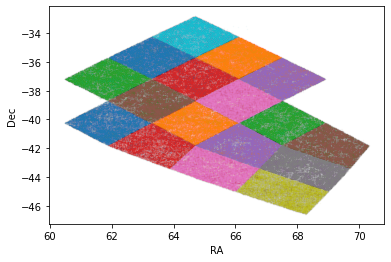

In [9]:
for extragal_data in extragalactic_cat.get_quantities(['ra', 'dec'], filters=['mag_i < 22'], return_iterator=True):
    plt.scatter(extragal_data['ra'], extragal_data['dec'], s=0.001, rasterized=True, marker='.')
plt.xlabel('RA');
plt.ylabel('Dec');

In [12]:
# get list of massive halos in a given redshift and mass range
mmin = 3.e14
zmax = 0.4

massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec'],\
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift<{zmax}'])


In [13]:
N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters available')

# Selecting the most massive one
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
print (f'The most massive cluster is in z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')
print(f'{ra_cl:.2f},{dec_cl:.2f}')

There are 23 clusters available
The most massive cluster is in z = 0.19, with mass = 1.24e+15 Msun
63.29,-39.65


Make filter to select background galaxies around the cluster identified in cosmoDC2 and perform corresponding cuts on 
the cosmoDC2 and object catalogs. We also add some WL quality cuts for the object catalog.

In [14]:
ra_min, ra_max = ra_cl-0.35, ra_cl+0.35
dec_min, dec_max = dec_cl-0.35, dec_cl+0.35
# get galaxies around and behind it
z_min = z_cl + 0.1

coord_filters = [
    f'ra >= {ra_min}',
    f'ra < {ra_max}',
    f'dec >= {dec_min}',
    f'dec < {dec_max}',
]

redshift_filters = [
    (np.isfinite, 'redshift'),
    f'redshift > {z_min}',
]

object_basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag == 0'),            # Error code returned by shape measurement code
    GCRQuery((np.isfinite, 'ext_shapeHSM_HsmShapeRegauss_sigma')), # Shape measurement uncertainty should not be NaN
]

object_properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),      # Shape measurement errors reasonable
    # New cut on blendedness:
    GCRQuery('blendedness < 10**(-0.375)')                      # Avoid spurious detections and those contaminated by blends
]


object_cat.add_quantity_modifier('shape_hsm_regauss_etot', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)

# Let's also define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 24.5',
]


In [15]:
# Load quanitities from cosmoDC2 catalog, using the filters we just defined.
extragal_data = extragalactic_cat.get_quantities(['ra', 'dec', 'shear_1', 'shear_2', 'ellipticity_1_true', 'ellipticity_2_true',\
                                                  'redshift', 'convergence', 'galaxy_id'], filters=(coord_filters + mag_filters + redshift_filters))

In [16]:
# Load quanitities from object catalog, using the filters we just defined.
# The field under scrutiny falls in tract 3448 of the object catalog. 
# Specifying that tract using native_filters speeds up the process but is not required.

object_data = object_cat.get_quantities(['ra', 'dec','ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2', 'id'],\
                                        native_filters=['tract == 3448'],
                                        filters=(coord_filters + object_basic_cuts + object_properties_cuts))

/global/homes/c/ccombet/.conda/envs/clmmenv/lib/python3.8/site-packages/GCRCatalogs-0.15.0-py3.8.egg/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/homes/c/ccombet/.conda/envs/clmmenv/lib/python3.8/site-packages/GCRCatalogs-0.15.0-py3.8.egg/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


### Match the 2 catalogs

In [17]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'extragal': extragal_data, 'object': object_data},
    linking_lengths=1.,
    catalog_len_getter=lambda x: len(x['ra']),
)

# first we need to know which rows are from the truth catalog and which are from the object
extragal_mask = results['catalog_key'] == 'extragal'
object_mask = ~extragal_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_extragal = np.bincount(results['group_id'][extragal_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

#results

In [18]:
# first, let's find our the IDs of the groups that have 1-to-1 extragal/object match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_extragal == 1) & (n_object == 1)))

# and then we can find the row indices in the *original* extragal/object catalogs for those 1-to-1 groups
extragal_idx = results['row_index'][one_to_one_group_mask & extragal_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]
print(len(extragal_idx), len(object_idx))

14999 14999


In [19]:
extragal_sc = SkyCoord(extragal_data['ra'][extragal_idx], extragal_data['dec'][extragal_idx], unit="deg")
object_sc = SkyCoord(object_data['ra'][object_idx], object_data['dec'][object_idx], unit="deg")

delta_ra = (object_sc.ra.arcsec - extragal_sc.ra.arcsec) * np.cos(np.deg2rad(0.5*(extragal_sc.dec.deg + object_sc.dec.deg)))
delta_dec = object_sc.dec.arcsec - extragal_sc.dec.arcsec
delta_arcsec = object_sc.separation(extragal_sc).arcsec

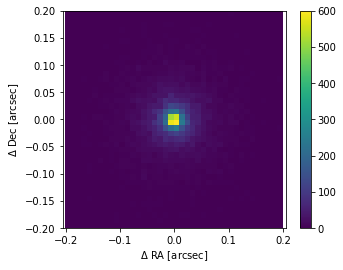

In [20]:
plt.figure(figsize=(5, 4))  # Pick a figuresize that will result in a square equal-axis plus colorbar
plt.hist2d(delta_ra, delta_dec, bins=40, range=((-0.2, +0.2), (-0.2, +0.2)));
plt.xlabel(r'$\Delta$ RA [arcsec]');
plt.ylabel(r'$\Delta$ Dec [arcsec]');
plt.colorbar();
plt.xlim(-0.2, +0.2)
plt.ylim(-0.2, +0.2)
plt.axis('equal');

#### Now that we have checked the match between object and extragal catalog, can proceed to WL mass reconstruction

In [21]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import sys
sys.path.append('../support')
from sampler import fitters
from astropy.table import Table

### First, dealing with the cosmoDC2 data.
CLMM requires shape measured according to the epsilon or reduced shear definition - so need to convert cosmoDC2 shear1 and shear2 to reduced shear. Whatever the definition, these become the `e1` and `e2` field of the CLMM cluster galaxy catalog.

In [22]:
e1, e2 = clmm.utils.convert_shapes_to_epsilon(extragal_data['shear_1'][extragal_idx],extragal_data['shear_2'][extragal_idx],\
                                              shape_definition='shear',kappa=extragal_data['convergence'][extragal_idx])

# Create the background galaxy catalog as astropy table
dat = Table([extragal_data['ra'][extragal_idx],extragal_data['dec'][extragal_idx],e1,\
      e2,extragal_data['redshift'][extragal_idx],extragal_data['galaxy_id'][extragal_idx]], \
      names=('ra','dec', 'e1', 'e2', 'z','id'))

# Instantiate a CLMM cluster object
cl_from_cosmoDC2 = clmm.GalaxyCluster('CL', ra_cl, dec_cl, z_cl, dat)   

### Second, doing the same for the DC2 object catalog.
In the object catalog, shapes are measured by `shapeHSM` which return ellipticities according to the chi definition. Need to convert to the epsilon definition, once again using the conversion helper function from CLMM. Aslo, the object catalog has no redshift information so we'll use the redshift of the matched galaxies in cosmoDC2.

In [23]:
e1, e2 = clmm.utils.convert_shapes_to_epsilon(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx],\
                                              object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx],\
                                              shape_definition='chi')
# The conversion may create to NaN
mask = np.isfinite(e1)

/global/homes/c/ccombet/.conda/envs/clmmenv/lib/python3.8/site-packages/clmm-0.2.0-py3.8.egg/clmm/utils.py:208: RuntimeWarning: invalid value encountered in sqrt


In [24]:
# Create the background galaxy catalog as astropy table
dat = Table([object_data['ra'][object_idx][mask],object_data['dec'][object_idx][mask],\
             e1[mask],\
             e2[mask],\
             extragal_data['redshift'][extragal_idx][mask],\
             object_data['id'][object_idx][mask]], \
            names=('ra','dec', 'e1', 'e2', 'z','id'), masked=True)


# Create the background galaxy catalog as astropy table
cl_from_objectDC2 = clmm.GalaxyCluster('CL', ra_cl, dec_cl, z_cl, dat)   

### Now, build the reduced tangential shear profile from both datasets.

In [25]:
cosmo = extragalactic_cat.cosmology
bin_edges = clmm.polaraveraging.make_bins(0.15, 4, 10, method='evenlog10width')

cl_from_cosmoDC2.compute_shear(geometry="flat")
profile_from_cosmoDC2 = cl_from_cosmoDC2.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

cl_from_objectDC2.compute_shear(geometry="flat")
profile_from_objectDC2 = cl_from_objectDC2.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)


#### and plot the results

(1e-05, 10)

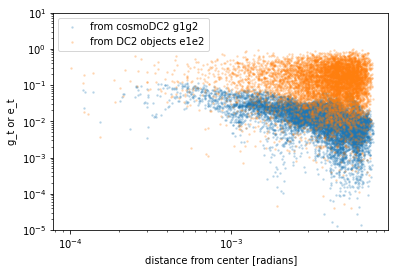

In [26]:
plt.scatter(cl_from_cosmoDC2.galcat['theta'],cl_from_cosmoDC2.galcat['gt'], 
            marker='.', s=10, alpha=0.2, label='from cosmoDC2 g1g2')
plt.scatter(cl_from_objectDC2.galcat['theta'],cl_from_objectDC2.galcat['gt'], 
            marker='.',s=10, alpha=0.2, label='from DC2 objects e1e2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance from center [radians]')
plt.ylabel('g_t or e_t')
plt.ylim([1.e-5,10])

(0.001, 1)

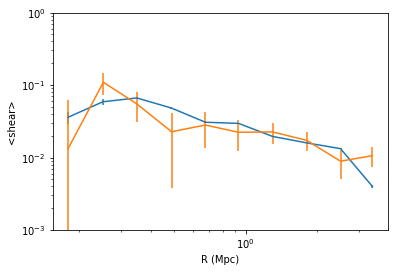

In [27]:
plt.errorbar(profile_from_cosmoDC2['radius'],profile_from_cosmoDC2['gt'],profile_from_cosmoDC2['gt_err'])
plt.errorbar(profile_from_objectDC2['radius'],profile_from_objectDC2['gt'],profile_from_objectDC2['gt_err'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('<shear>')
plt.ylim([1.e-3,1])

To account for shape noise from intrinsic ellipticities, we can use the shears and unlensed ellipticities available in the cosmoDC2 catalog to build lensed ellipticities. The latter can then be used to bluid a CLMM cluster object. The resulting tangential shear profile will then include shape noise.

In [28]:
def calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es = es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.real(e), np.imag(e)


In [29]:
es1 = extragal_data['ellipticity_1_true']
es2 = extragal_data['ellipticity_2_true']
gamma1 = extragal_data['shear_1']
gamma2 = extragal_data['shear_2']
kappa = extragal_data['convergence']

In [30]:
extragal_data['ellipticity_1'] = calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa)[0]
extragal_data['ellipticity_2'] = calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa)[1]


Make a new CLMM cluster object with ellipticity definition as e1 and e2

In [31]:
dat = Table([extragal_data['ra'][extragal_idx],extragal_data['dec'][extragal_idx],
             extragal_data['ellipticity_1'][extragal_idx],
             extragal_data['ellipticity_2'][extragal_idx],
             extragal_data['redshift'][extragal_idx],
             extragal_data['galaxy_id'][extragal_idx]],
            names=('ra','dec', 'e1', 'e2', 'z','id'))

cl_from_cosmoDC2_with_e1e2 = clmm.GalaxyCluster('CL', ra_cl, dec_cl, z_cl, dat) 

Compute the reducede tangential shear profile

In [32]:
cl_from_cosmoDC2_with_e1e2.compute_shear(geometry="flat")
profile_from_cosmoDC2_with_e1e2 = cl_from_cosmoDC2_with_e1e2.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

(1e-05, 10)

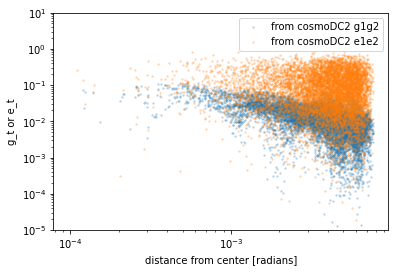

In [33]:
plt.scatter(cl_from_cosmoDC2.galcat['theta'],cl_from_cosmoDC2.galcat['gt'], marker='.', s=10,
            label='from cosmoDC2 g1g2', alpha=0.2)
plt.scatter(cl_from_cosmoDC2_with_e1e2.galcat['theta'],cl_from_cosmoDC2_with_e1e2.galcat['gt'], marker='.',s=10,
            label='from cosmoDC2 e1e2', alpha=0.2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance from center [radians]')
plt.ylabel('g_t or e_t')
plt.ylim([1.e-5,10])

(0.002, 0.3)

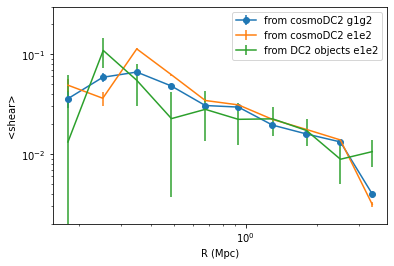

In [34]:
plt.errorbar(profile_from_cosmoDC2['radius'],profile_from_cosmoDC2['gt'],profile_from_cosmoDC2['gt_err'], 
             marker='o',label='from cosmoDC2 g1g2')
plt.errorbar(profile_from_cosmoDC2_with_e1e2['radius'],profile_from_cosmoDC2_with_e1e2['gt'],
             profile_from_cosmoDC2['gt_err'],label='from cosmoDC2 e1e2')
plt.errorbar(profile_from_objectDC2['radius'],profile_from_objectDC2['gt'],profile_from_objectDC2['gt_err'], 
             label='from DC2 objects e1e2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('<shear>')
plt.ylim([2.e-3,0.3])

From cosmoDC2 (orange and blue profiles above), we see the impact of shape noise at low radii (orange/blue =w/wo intrinsic ellipticities), where the number of galaxies per bin is small (see below).

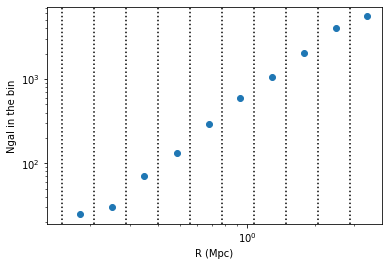

In [35]:
plt.scatter(profile_from_cosmoDC2['radius'], profile_from_cosmoDC2['n_src'], marker='o')
[plt.axvline(x=r, ymin=0, ymax=1e3, color='k', linestyle=':') for r in profile_from_cosmoDC2['radius_min']]
plt.ylabel('Ngal in the bin')
plt.xlabel('R (Mpc)')
plt.xscale('log')
plt.yscale('log')
